# 2) Bass diffusion model for the number of youtube users¶

In [1]:
# !pip install particles
import scipy.stats as stats
import particles
from particles import distributions as dists  
from particles import state_space_models as ssm  
from particles.collectors import Moments 
from particles import mcmc

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

In [2]:
#Q1
#Loading the YouTube Dataset
df = pd.read_csv('youtube.csv') 
df.head(2)

,Year,Monthly active users
0,2005,1946322
1,2006,19878248


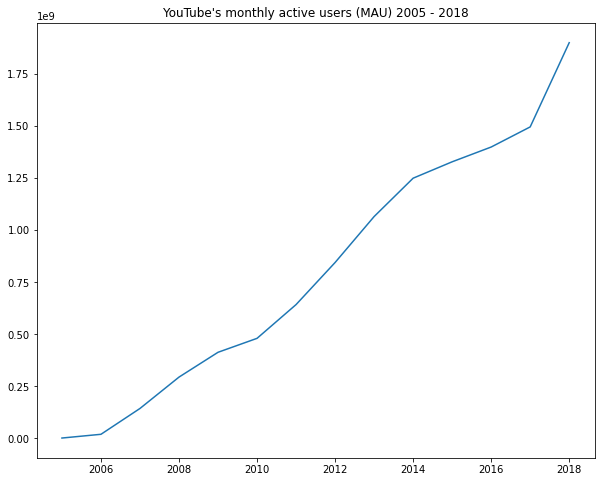

In [3]:
#Q2
#Plotting time series
fig = plt.figure(figsize=(10,8))
plt.plot(df['Year'],df['Monthly active users'])
plt.title("YouTube's monthly active users (MAU) 2005 - 2018")
plt.show()

We can see that the MAU follows an upward positive trend and is relatively linear in growth rate. 

In [4]:
#From demo code done in class
class ShiftedBinomial(dists.DiscreteDist):
    """Shifted Binomial(n,p) distribution."""
    def __init__(self, n=1, p=0.5, loc=0):
        self.n = n
        self.p = p
        self.loc = loc

    def rvs(self, size=None):
        return stats.binom.rvs(self.n, self.p, loc = self.loc, size = size)

    def logpdf(self, x):
        return stats.binom.logpmf(x, self.n, self.p, self.loc)

    def ppf(self, u):
        return stats.binom.ppf(u, self.n, self.p, self.loc)

In [5]:
#Q3
class Bass(ssm.StateSpaceModel): 
    """Subclass: State Space Model."""
    def PX0(self):
        #X_0 ∼ Binomial(N, β_0),
        return dists.Binomial(N, self.beta0)
    
    def PX(self, t, Xt_1):
        #Xt ∼ ShiftedBinomial(N − X_{t−1}, α + βX_{t−1}/N, X_{t−1}),
        return ShiftedBinomial(N - Xt_1, self.alpha + self.beta * Xt_1/N, Xt_1)
    
    def PY(self, t , xp, x): 
        #Yt ∼ TruncNormal(X_t, σ^2),
        return dists.TruncNormal(mu=x, sigma=self.sigma, a=0, b=np.inf)

In [6]:
#Q4 
Xt = 1.5*10**8
sig = 0.3*10**8

# setting up prior distributions
beta_0 = dists.Beta(1,100)
alpha = dists.Beta(1,100)
beta = dists.Beta(2,20)
sigma = dists.TruncNormal(Xt, sig, a=0, b = np.inf)

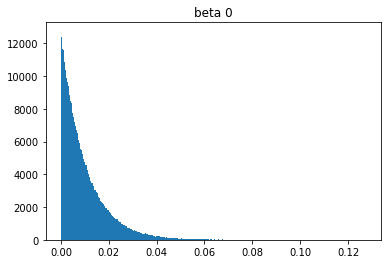

In [7]:
temp = beta_0.rvs(size=1000000) 
plt.hist(temp, bins=1000)
plt.title("beta 0")
plt.show()

beta0 is modeling the uncertainty of people on the platform from x0

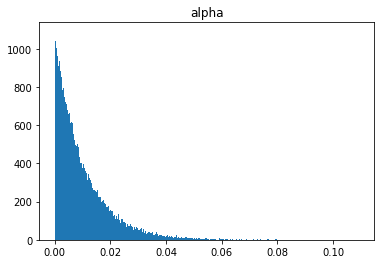

In [8]:
temp = alpha.rvs(size=100000) 
plt.hist(temp, bins=1000)
plt.title("alpha")
plt.show()

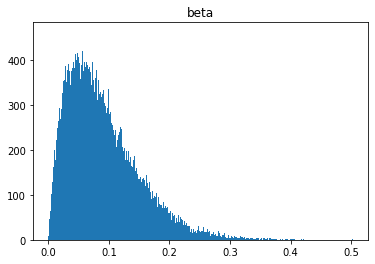

In [9]:
temp = beta.rvs(size=100000) 
plt.hist(temp, bins=1000)
plt.title("beta")
plt.show()

alpha and beta show the number of people who arent yet on the platform and will adopt with a probability 𝛼+𝛽𝑋𝑡−1

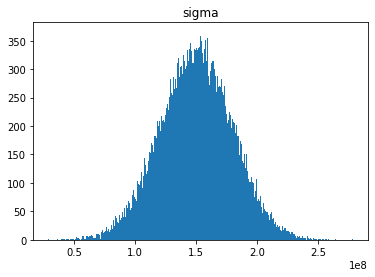

In [10]:
temp = sigma.rvs(size=100000) 
plt.hist(temp, bins=1000)
plt.title("sigma")
plt.show()

Std/variability of the measurement of $Y_t$

In [11]:
#Q5 
N = 7700000000
n_iter = 5000    
n_particles = 20

prior_param = {'beta0':dists.Beta(1,100),
              'beta':dists.Beta(2,20),
              'alpha':dists.Beta(1,100), 
              'sigma':dists.TruncNormal(Xt, sig, a=0, b=np.inf)}

# construct the joint prior distribution 
prior = dists.StructDist(prior_param) 

In [12]:
# %%timeit
# particle marginal Metropolis–Hastings 
pmmh = mcmc.PMMH(ssm_cls = Bass, prior = prior, 
                 data = df["Monthly active users"].values, 
                 Nx = n_particles, niter = n_iter)
pmmh.run() 

In [13]:
print("Acceptance Rate: ", pmmh.acc_rate)
print("Time: ",pmmh.cpu_time)

Acceptance Rate:  0.30686137227445487
Time:  31.123666417000003


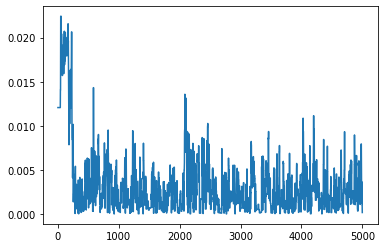

In [14]:
# convergence diagnostics: trace plots
iteration = np.arange(1, n_iter+1)
plt.plot(iteration, pmmh.chain.theta['beta0'])
plt.show()

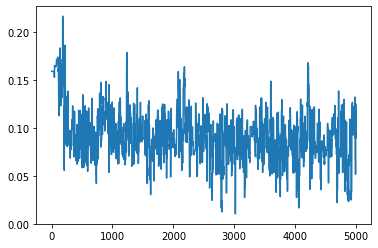

In [15]:
plt.plot(iteration, pmmh.chain.theta['beta'])
plt.show()

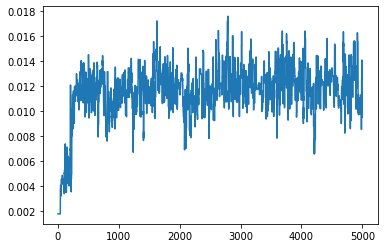

In [16]:
plt.plot(iteration, pmmh.chain.theta['alpha'])
plt.show()

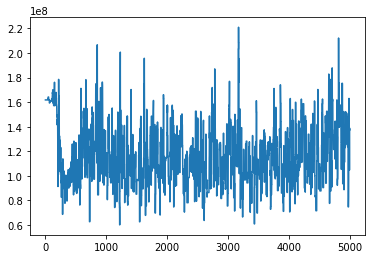

In [17]:
plt.plot(iteration, pmmh.chain.theta['sigma'])
plt.show()

We can see that each of the above plots show stationarity after a a few hundred runs. Lets look at the cumulative sum for further convergence diagnostics. 

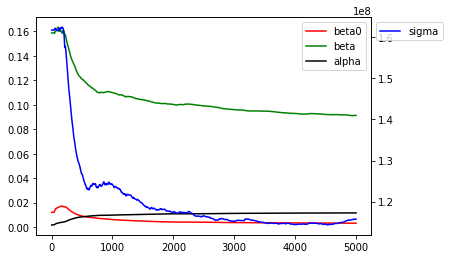

In [18]:
# look at rolling cumsum for iterations to better understand cutoff/burnin
iteration = np.arange(1, n_iter+1)
fig, ax1 = plt.subplots()
ax1.plot(iteration, np.cumsum(pmmh.chain.theta['beta0']) / iteration, color='red', label="beta0")
ax1.plot(iteration, np.cumsum(pmmh.chain.theta['beta']) / iteration, color='green', label="beta")
ax1.plot(iteration, np.cumsum(pmmh.chain.theta['alpha']) / iteration, color='black', label="alpha")
ax2 = ax1.twinx()
ax2.plot(iteration, np.cumsum(pmmh.chain.theta['sigma']) / iteration, color="blue", label="sigma")
ax1.legend()
ax2.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [19]:
#confirmed to be accurate with professor
print("beta0: ", np.mean(pmmh.chain.theta['beta0']))
print("alpha: ", np.mean(pmmh.chain.theta['alpha']))
print("beta: ", np.mean(pmmh.chain.theta['beta']))
print("sigma: ", np.mean(pmmh.chain.theta['sigma']))

beta0:  0.0031711620170109126
alpha:  0.011583143536074337
beta:  0.0913246748651801
sigma:  115733066.80612642


In [20]:
burnin = 500 #set manually.. could be 500<x<25000
sigma_hat = np.mean(pmmh.chain.theta['sigma'][burnin:])
alpha_hat = np.mean(pmmh.chain.theta['alpha'][burnin:])
beta0_hat = np.mean(pmmh.chain.theta['beta0'][burnin:])
theta_hat = np.mean(pmmh.chain.theta['beta'][burnin:])

print("Posterior mean of parameters: ", theta_hat)

Posterior mean of parameters:  0.0880227715309349


In [21]:
#Q7
bass = Bass(sigma = sigma_hat, 
            alpha = alpha_hat, 
            beta0 = beta0_hat, 
            beta = theta_hat)

In [22]:
# %%timeit
fk = ssm.Bootstrap(ssm = bass, data = df["Monthly active users"].values) 
particle_filter = particles.SMC(fk = fk, N = 1000, resampling = 'systematic', 
                                ESSrmin = 1, collect=[Moments()])

particle_filter.run() 

In [23]:
print("ESS: ", particle_filter.summaries.ESSs) 

ESS:  [999.9999990180652, 999.9999887244051, 999.9999918960038, 999.9999983930935, 999.9999984135587, 999.9999722201377, 999.9999872873703, 999.9999981116904, 999.9999302708811, 999.9998484000452, 999.9999850113176, 999.9999363234973, 999.9996268929647, 999.9999058855431]


At each step the samples are representing well the filtering distributions and is efficiently capturing 99% of particules used. If they were low, we would be skeptical of the results. 

In [24]:
print("moments: ", particle_filter.summaries.moments) #Q8

moments:  [{'mean': 19382226.242018998, 'var': 18009234.75}, {'mean': 112746312.66970688, 'var': 121256510.0}, {'mean': 213073212.60157496, 'var': 232082000.0}, {'mean': 320660187.7596477, 'var': 377018064.0}, {'mean': 435776314.89867896, 'var': 553802144.0}, {'mean': 558656408.0184965, 'var': 783224768.0}, {'mean': 689488847.9969995, 'var': 997499264.0}, {'mean': 828410056.9930542, 'var': 1233298560.0}, {'mean': 975490304.3849083, 'var': 1489404672.0}, {'mean': 1130729566.920217, 'var': 1849844992.0}, {'mean': 1294043338.3403335, 'var': 2218396160.0}, {'mean': 1465255928.8241742, 'var': 2498652928.0}, {'mean': 1644095691.670907, 'var': 2912208896.0}, {'mean': 1830186461.2317753, 'var': 3321312256.0}]


In [25]:
# to extract filtering means and variances
filtering_means = [m['mean'] for m in particle_filter.summaries.moments]
filtering_variances = [m['var'] for m in particle_filter.summaries.moments]

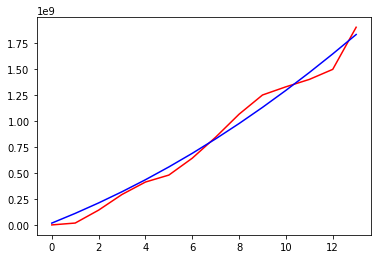

In [26]:
T = 13
plt.plot(np.arange(0,T+1), df['Monthly active users'], color='red')
plt.plot(np.arange(0,T+1), filtering_means, color = "blue")

Our filtering means follow the observed data Yt and shows that there is a latent state close to the data. Which suggests there is little error in the measurement.  

In [27]:
#Q9 
X,Y = bass.simulate(T+1)

fk = ssm.Bootstrap(ssm = bass, data = Y) # create FeynmanKac object for the bootstrap particle filter
particle_filter = particles.SMC(fk = fk, N = 1000, resampling = 'systematic', 
                   ESSrmin = 1, collect = [Moments()], 
                   store_history = True)
particle_filter.run() 

In [28]:
# %%timeit
M = 1000
Z = particle_filter.hist.backward_sampling(M = M)
Z = np.array(Z)

In [29]:
smoothing_means = np.mean(Z, axis = 1)

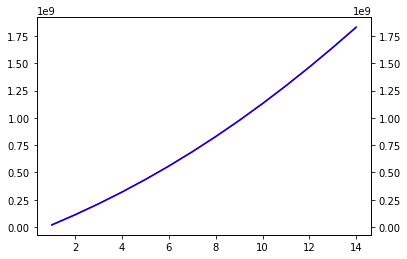

In [30]:
fig, ax1 = plt.subplots()
ax1.plot( np.arange(1,T+2), filtering_means, color="red")
ax2 = ax1.twinx()
ax2.plot(np.arange(1,T+2), smoothing_means, color="blue")
plt.show()

If we use all or some of the data to learn the latent states, there is no difference. Conditioning on little or all of the data tells us the same amount about the latent states since the data is very informative.